# Advertising on iffy newssites

The [Iffy Index of Unreliable Sources](https://iffy.news/index/#methodology) by Media Bias/Fact Check (MBFC) maintains a list of news sites that regularly fail fact-checks and is a widely used research tool in the field of mis/disinformation. The data contains domain names and a compilation of credibility ratings from different sources. The list is compiled by a team of researchers, accepts feedback from publishers and is continually reconsidering past ratings.

It's somewhat common for websites to have an ads.txt (Authorized Digital Sellers) URL when they generate revenue with their file. It specifies a text file that companies can host on their web servers. This file contains information about which advertisers are allowed to operate on the site. By parsing this information for news sites in the dataset we might be able to find interesting relationships between sites' credibility and their advertisements.

In [12]:
import pandas as pd

newssites = pd.read_excel("iffy_index.xlsx")
newssites.head()

,Domain name,MBFC Factual,MBFC Cat,MBFC Cred,Global Site Rank,Wikipedia article,Misinfo.me,Fact-checks
0,100percentfedup.com,L,FN,L,72.284,NaN,-0.91,100 Percent Fed Up
1,10news.one,L,FN,L,"30,000,000",NaN,0.00,10News.one
2,12minutos.com,L,FN,L,276.039,NaN,-1.00,12minutos.com
3,163.com,M,FN,L,309,W,0.23,NetEase
4,1tv.ru,M,FN,L,2.598,W,0.28,Channel One Russia


Misinfo.me rates the sites' credibility from low (-1.0) to high (1.0). To only include the most interesting domain names, we will filter out those that have a positive credibility rating. Next, we will create a new column and add the prefix 'https://' to every domain name to be able to use them with the `requests` library. This library is needed to send HTTP requests to the ads.txt URLs. 

In [13]:
newssites = newssites[newssites["Misinfo.me"] >= 0]
newssites["Domain name"] = "https://" + newssites["Domain name"]

## Extracting the data

The Iffy Index was last updated in January 2024, so some of the sites may no longer be functioning. Moreover, not all sites in the dataset will have an ads.txt file. According to IAB Technology Laboratory, who introduced the initiative, 44% of publishers had ads.txt files in 2017 (IAB, 2017). We will send a HTTP request to each domain's ads.txt URL, and store its text content if available. Ads.txt files are uploaded to the root directory of a website, e.g. *example.com/ads.txt*. 

In [14]:
import requests
import warnings

warnings.filterwarnings("ignore")

def request_adstxt(urls, timeout=10):
    adstxt_files = []

    headers = {
        "User-Agent":
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
        "Accept":
        "text/plain"
    }

    for url in urls:
        ads_url = f"{url}/ads.txt"
        try:
            response = requests.get(ads_url, headers=headers, timeout=timeout, verify=False)
            if response.status_code == 200:
                text = response.text.lower()
                # Filter out cases where the server returns a HTML error page
                if "hmtl" not in text and "body" not in text and "div" not in text and "span" not in text:
                    adstxt_files.append({"domain": url, "text": text})
        except:
            # If an error occurs, skip the URL
            pass

    return adstxt_files

newssite_urls = newssites["Domain name"].tolist()
adstxt_content = request_adstxt(newssite_urls[0:10])

How many of the publishers in the dataset had a functioning news website with an ads.txt URL?

In [15]:
percentage_adstxt = (len(adstxt_content) / len(newssites)) * 100

print("Percentage of domains with a functioning site and ads.txt URL: {:.2f}%".format(percentage_adstxt))

Percentage of domains with a functioning site and ads.txt URL: 0.72%


Ads.txt files need to be a certain format in order for them to be crawled by advertising networks. [Google Adsense](https://support.google.com/adsense/answer/12171612?hl=en) has set up a few formatting guidelines to follow. Each line in the file uses the CSV style formatting, and can have three to four values. Comments are signalled by a # character. We will use a regular expression to extract all of these values from the ads.txt files, excluding any comments.

In [31]:
import re

def parse_adstxt(adstxt_files):
    all_data = []

    for file in adstxt_files:
        # Regex to parse the information in the ads.txt file
        pattern = r'^(?!#)([^,]+),\s*([\w-]+),\s*(\w+)(?:,\s*([\w\d]+))?.*'

        for line in file["text"].split("\n"):
            match = re.match(pattern, line)
            if match:
                ad_network, seller_account_id, account_type, tag_id = match.groups()

                # Check if optional tag_id is present in the line
                if tag_id is None:
                    tag_id = ""

                data = {
                    "Domain name": file["domain"],
                    "Ad network": ad_network,
                    "Seller account ID": seller_account_id,
                    "Account type": account_type,
                    "Tag ID": tag_id
                }
                all_data.append(data)

    df = pd.DataFrame(all_data)
    return df

ads = parse_adstxt(adstxt_content)
ads.head()

,Domain name,Ad network,Seller account ID,Account type,Tag ID
0,https://24jours.com,google.com,pub-3644207740963104,direct,f08c47fec0942fa0
1,https://4chan.org,pubfuture.com,6577d96458f9186175745535,direct,
2,https://4chan.org,33across.com,0015a00002egvrsaay,reseller,bbea06d9c4d2853c
3,https://4chan.org,admanmedia.com,2026,direct,
4,https://4chan.org,appnexus.com,15349,reseller,f5ab79cb980f11d1


## Data visualisation

1. What is the most popular ads.txt partner for all of the publishers? 
2. How do the publishers with the most advertising partners rank on MBFC?

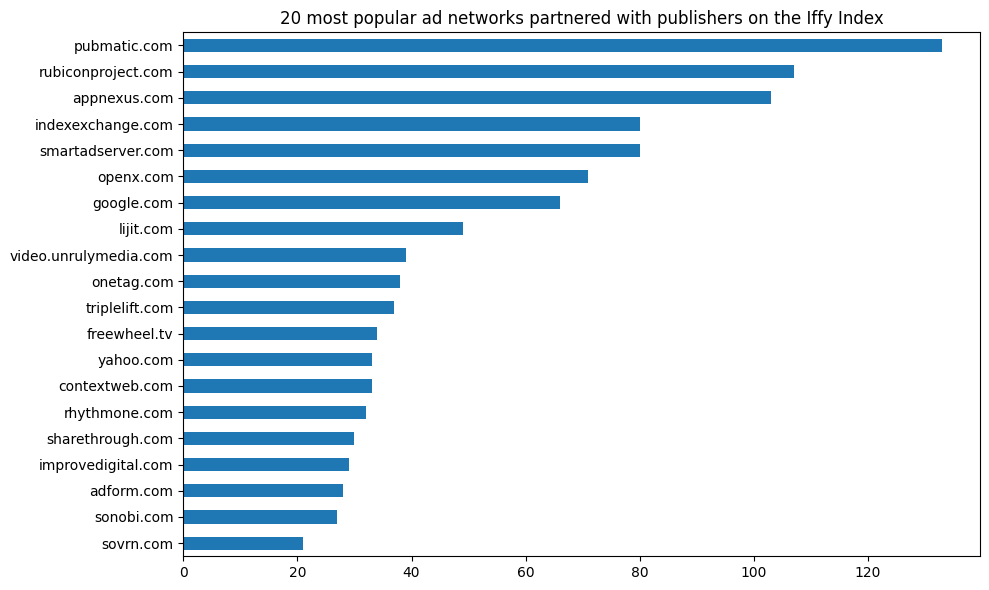

In [66]:
import matplotlib.pyplot as plt

ad_network_counts = ads['Ad network'].value_counts()

# Get the top 20 most common ad networks
top_20_ad_networks = ad_network_counts.head(20)

plt.figure(figsize=(10, 6))
top_20_ad_networks.sort_values().plot(kind="barh")
plt.title("20 most popular ad networks partnered with publishers on the Iffy Index")
plt.ylabel("")
plt.tight_layout()
plt.show()

merge data

In [68]:
merged_data = pd.merge(ads, newssites, on="Domain name", how="inner")

## Sources

https://iffy.news/index/#methodology (Golding, 2020)

https://support.google.com/adsense/answer/7679060?hl=en

https://web.archive.org/web/20180321051456/http://www.adopsinsider.com/ad-exchanges/ads-txt-adoption/ (IAB, 2017)